In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import scipy

from sklearn.model_selection import train_test_split
from sklearn import metrics
from category_encoders import BinaryEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import f_classif, SelectPercentile
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import f_classif, SelectPercentile
from sklearn.tree import DecisionTreeClassifier

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

df = pd.read_csv("./data/loan_dataset.csv")
df.head()

,id,grade,annual_inc,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,od_ratio,bad_loan
0,11454641,A,100000.0,1,1,RENT,26.27,credit_card,36 months,1,NaN,43.2,0.0,0.160624,0
1,9604874,A,83000.0,0,4,OWN,5.39,credit_card,36 months,0,NaN,21.5,0.0,0.810777,0
2,9684700,D,78000.0,0,11,MORTGAGE,18.45,debt_consolidation,60 months,1,NaN,46.3,0.0,0.035147,1
3,9695736,D,37536.0,0,6,MORTGAGE,12.28,medical,60 months,0,NaN,10.7,0.0,0.534887,1
4,9795013,D,65000.0,0,11,MORTGAGE,11.26,debt_consolidation,36 months,0,NaN,15.2,0.0,0.166500,0


In [2]:
# bad_loan : 1 when load not paid, 0 good loan

# EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     20000 non-null  int64  
 1   grade                  20000 non-null  object 
 2   annual_inc             20000 non-null  float64
 3   short_emp              20000 non-null  int64  
 4   emp_length_num         20000 non-null  int64  
 5   home_ownership         18509 non-null  object 
 6   dti                    19846 non-null  float64
 7   purpose                20000 non-null  object 
 8   term                   20000 non-null  object 
 9   last_delinq_none       20000 non-null  int64  
 10  last_major_derog_none  574 non-null    float64
 11  revol_util             20000 non-null  float64
 12  total_rec_late_fee     20000 non-null  float64
 13  od_ratio               20000 non-null  float64
 14  bad_loan               20000 non-null  int64  
dtypes:

In [4]:
df.describe(include=[np.object_])

,grade,home_ownership,purpose,term
count,20000,18509,20000,20000
unique,7,3,12,3
top,B,MORTGAGE,debt_consolidation,36 months
freq,6042,9844,12337,14969


In [5]:
df.describe().round(2)

,id,annual_inc,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,od_ratio,bad_loan
count,20000.00,20000.00,20000.00,20000.00,19846.00,20000.00,574.00,20000.00,20000.00,20000.00,20000.0
mean,7590662.08,73349.58,0.11,6.82,16.59,0.55,0.76,55.96,0.29,0.50,0.2
std,1609593.30,45198.57,0.32,3.77,7.59,0.50,0.43,42.12,3.11,0.29,0.4
min,586040.00,8412.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
25%,6206282.75,47000.00,0.00,3.00,10.85,0.00,1.00,38.80,0.00,0.26,0.0
50%,7378896.50,65000.00,0.00,7.00,16.19,1.00,1.00,57.10,0.00,0.51,0.0
75%,8766234.75,88000.00,0.00,11.00,22.06,1.00,1.00,73.90,0.00,0.75,0.0
max,11454641.00,1000000.00,1.00,11.00,34.99,1.00,1.00,5010.00,96.47,1.00,1.0


### Initial analyses:

- mean of the total bad_loans is 0.2, hence most borrowers don't default on their loans
- Annual_inc, revol_util and total_rec_late_fee have outliers in the data


In [6]:
df.isnull().sum()

id                           0
grade                        0
annual_inc                   0
short_emp                    0
emp_length_num               0
home_ownership            1491
dti                        154
purpose                      0
term                         0
last_delinq_none             0
last_major_derog_none    19426
revol_util                   0
total_rec_late_fee           0
od_ratio                     0
bad_loan                     0
dtype: int64

A vast majority of last_major_derog_none values are missing, hence we will drop that column

In [7]:
df.drop(["id", "last_major_derog_none"], axis=1, inplace=True)

In [8]:
# missing values imputation
df.home_ownership = df.home_ownership.fillna(df.home_ownership.value_counts().index[0])
df.dti = df.dti.fillna(df.dti.mean())

### Numeric distribution

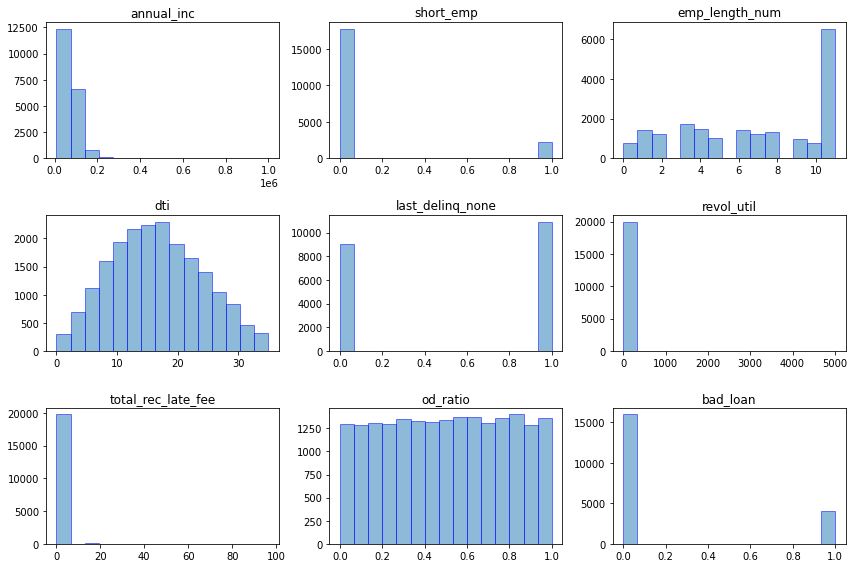

In [9]:
df.hist(figsize=(12, 8), bins=15, grid=False, ec="b", alpha=0.5)
plt.tight_layout()

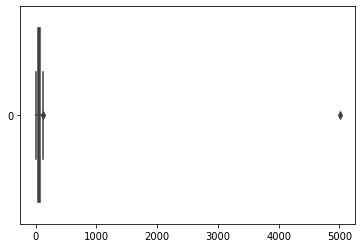

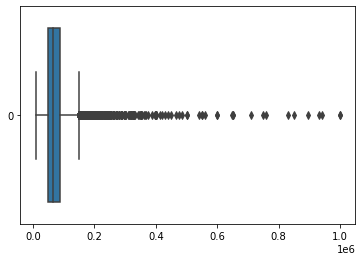

In [10]:
for c in df[["revol_util", "annual_inc"]]:
    sns.boxplot(data = df[c], orient='h')
    plt.show()

### Remove outliers using IQR method

In [11]:
def remove_outliers(df, out_cols, T=1.5, verbose=True):
    # Copy of df
    new_df = df.copy()
    init_shape = new_df.shape
    
    # For each column
    for c in out_cols:
        q1 = new_df[c].quantile(.25)
        q3 = new_df[c].quantile(.75)
        col_iqr = q3 - q1
        col_max = q3 + T * col_iqr
        col_min = q1 - T * col_iqr
        
        # Filter data without outliers and ignoring nan
        filtered_df = new_df[(new_df[c] <= col_max) & (new_df[c] >= col_min)]
        if verbose:
            n_out = new_df.shape[0] - filtered_df.shape[0] 
            print(f" Columns {c} had {n_out} outliers removed")
        new_df = filtered_df
            
    if verbose:
        # Print shrink percentage
        lines_red = df.shape[0] - new_df.shape[0]
        print(f"Data reduced by {lines_red} lines, or {lines_red/df.shape[0]*100:.2f} %")
    
    return new_df

df = remove_outliers(df, ["annual_inc", "revol_util"])

 Columns annual_inc had 926 outliers removed
 Columns revol_util had 2 outliers removed
Data reduced by 928 lines, or 4.64 %


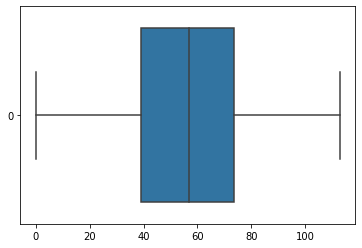

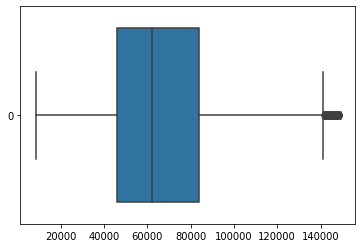

In [12]:
for c in df[["revol_util", "annual_inc"]]:
    sns.boxplot(data = df[c], orient='h')
    plt.show()

### Categorical distribution

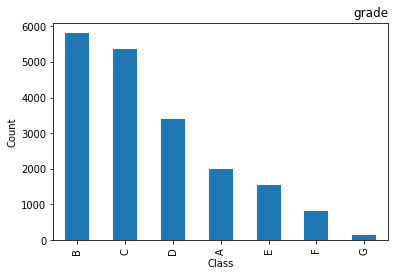

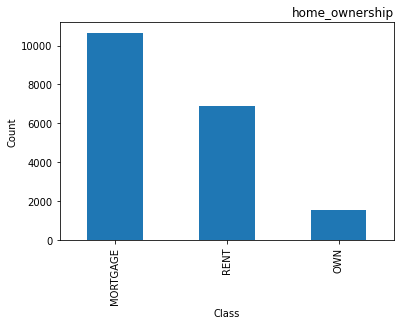

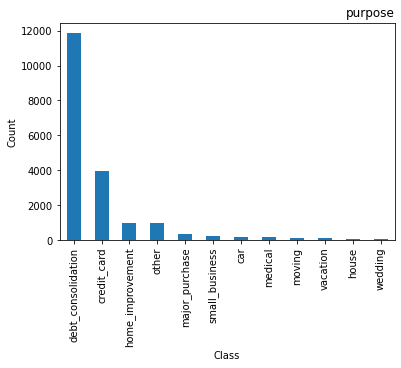

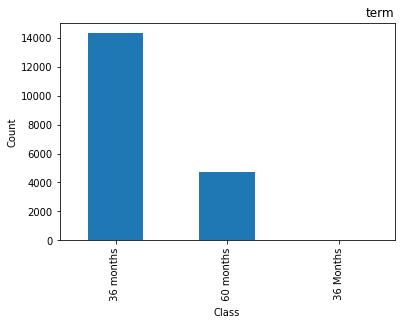

In [13]:
for col in df.select_dtypes(include=["object"]).columns:
    df[col].value_counts().plot(kind="bar")
    plt.xlabel("Class")
    plt.xticks(rotation=90)
    plt.ylabel("Count")
    plt.title(col, loc="right")
    plt.show()

<AxesSubplot:>

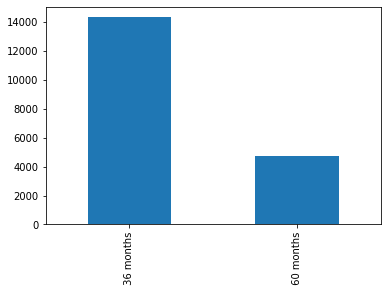

In [14]:
df.term = df.term.str.lower()
df.term.value_counts().plot(kind="bar")

### Feature: Grade

<AxesSubplot:xlabel='grade', ylabel='count'>

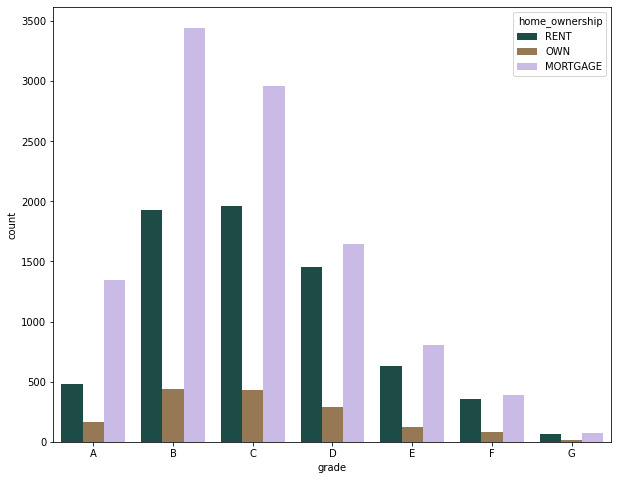

In [15]:
plt.figure(figsize=(10, 8))
sns.countplot(x=df.grade.sort_values(), hue=df.home_ownership, data=df, palette="cubehelix")

With lower loan grade classes, tend to have higher concentration of rented houses as compared to mortgage

<AxesSubplot:xlabel='grade', ylabel='count'>

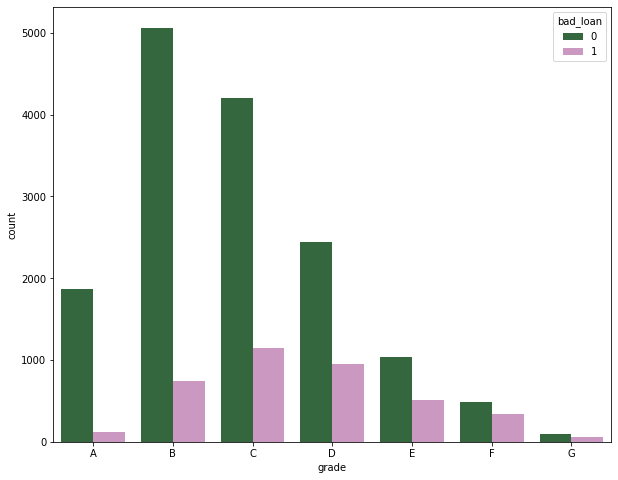

In [16]:
plt.figure(figsize=(10, 8))
sns.countplot(x=df.grade.sort_values(), hue=df.bad_loan, data=df, palette="cubehelix")

Grade C has the most defaulted on loans, whereas grade B has the most successful payments

### Feature: Annual Income

<AxesSubplot:xlabel='annual_inc', ylabel='dti'>

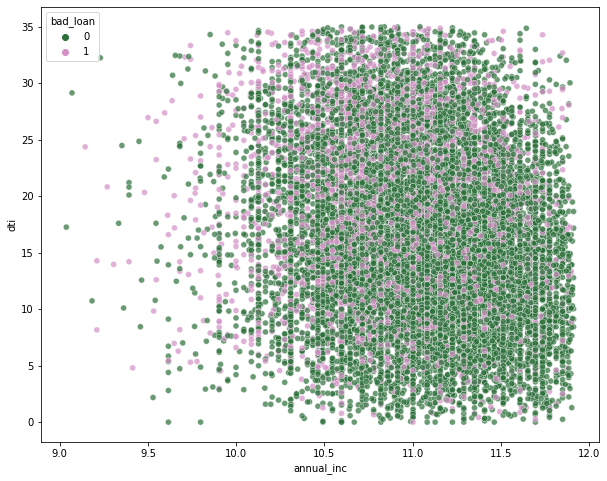

In [17]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x=np.log(df.annual_inc), y=df.dti, hue=df.bad_loan, palette="cubehelix", alpha=0.7)

In [18]:
df.annual_inc.corr(df.dti)

-0.19064621212625207

### As is evident from the scatterplot and the correlation factor, the greater debt to income ratio tend to default more on their loans

### Borrowers from lower-middle-income class with high debt-to-income ratio tend to default the most

### Feature: Home Ownership

<AxesSubplot:xlabel='home_ownership', ylabel='count'>

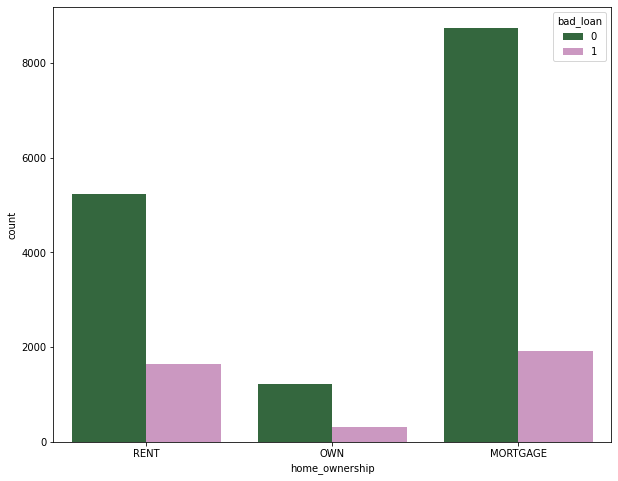

In [19]:
plt.figure(figsize=(10, 8))
sns.countplot(x=df.home_ownership, hue=df.bad_loan, data=df, palette="cubehelix")

Relative to their borrowing size, borrowers on rental homes tend to default most on their loans

### Feature: Term

<AxesSubplot:xlabel='term', ylabel='count'>

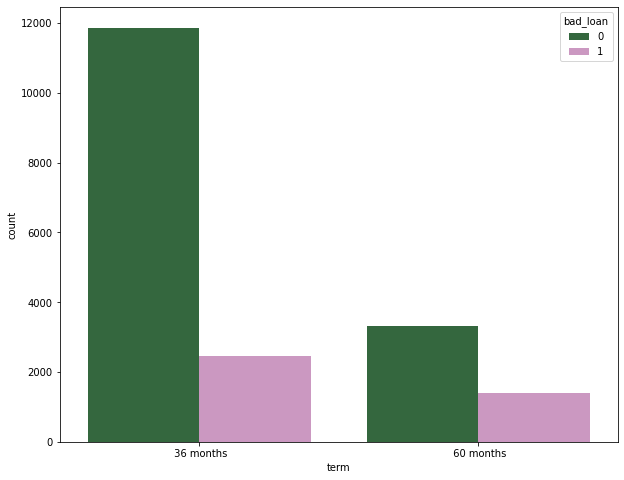

In [20]:
plt.figure(figsize=(10, 8))
sns.countplot(x=df.term, hue=df.bad_loan, data=df, palette="cubehelix")

Defaults are much more common in 60 month terms than their 36 month counterpart

<AxesSubplot:xlabel='dti', ylabel='term'>

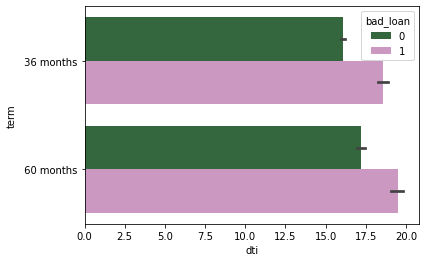

In [21]:
sns.barplot(x=df.dti, y=df.term, hue=df.bad_loan, palette="cubehelix")


### Feature: Last Deliquency

<AxesSubplot:xlabel='last_delinq_none', ylabel='count'>

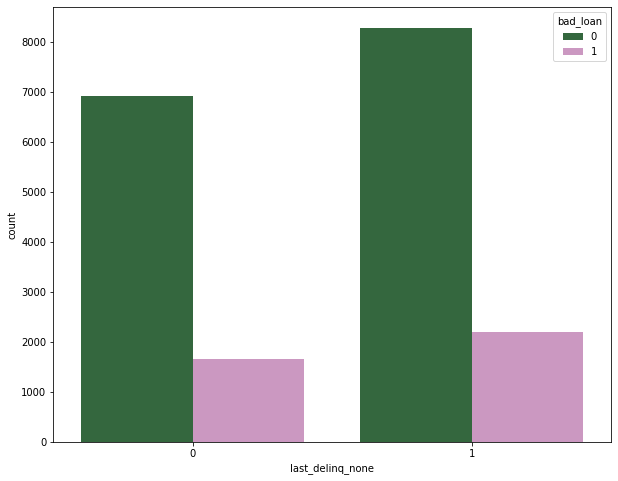

In [22]:
plt.figure(figsize=(10, 8))
sns.countplot(x=df.last_delinq_none, hue=df.bad_loan, data=df, palette="cubehelix")

A previous delinquecy doesn't have too great an impact on defaulting probabilities

### Feature: Purpose

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'credit_card'),
  Text(1, 0, 'debt_consolidation'),
  Text(2, 0, 'medical'),
  Text(3, 0, 'other'),
  Text(4, 0, 'home_improvement'),
  Text(5, 0, 'small_business'),
  Text(6, 0, 'major_purchase'),
  Text(7, 0, 'vacation'),
  Text(8, 0, 'car'),
  Text(9, 0, 'house'),
  Text(10, 0, 'moving'),
  Text(11, 0, 'wedding')])

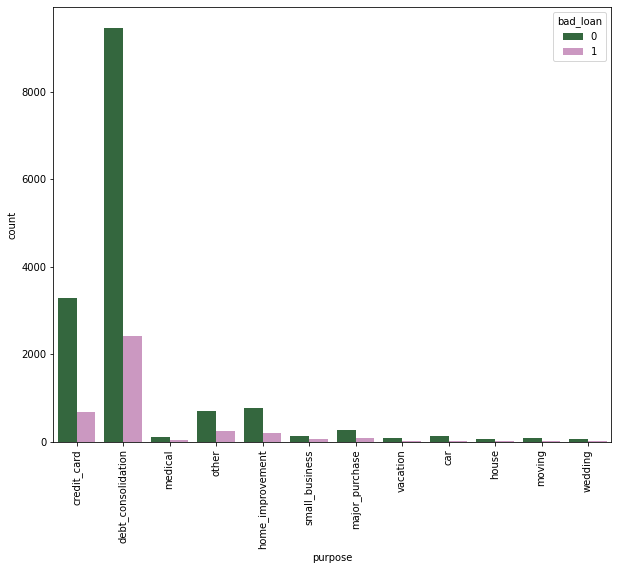

In [23]:
plt.figure(figsize=(10, 8))
sns.countplot(x=df.purpose, hue=df.bad_loan, palette="cubehelix")
plt.xticks(rotation=90)

### Debt consolidation and credit cards are by-far the leading purpose why borrowers get loans

For the proportion of borrowers, the default rate is equivalent for for good/bad 90 day rating

### Feature: Revolving line utilization rate

/home/dhruv/Desktop/projects/Data Science Portfolio/venv/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='annual_inc', ylabel='revol_util'>

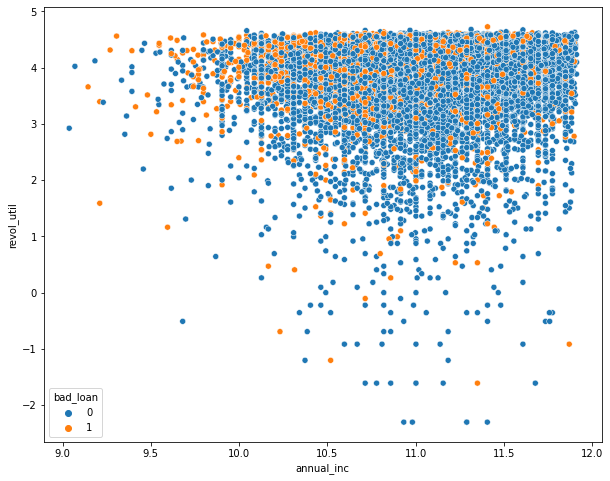

In [24]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x=np.log(df.annual_inc), y=np.log(df.revol_util), hue=df.bad_loan)

The lowest income earners have the most late fees 

### Feature: Late fees received to date

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'credit_card'),
  Text(1, 0, 'debt_consolidation'),
  Text(2, 0, 'medical'),
  Text(3, 0, 'other'),
  Text(4, 0, 'home_improvement'),
  Text(5, 0, 'small_business'),
  Text(6, 0, 'major_purchase'),
  Text(7, 0, 'vacation'),
  Text(8, 0, 'car'),
  Text(9, 0, 'house'),
  Text(10, 0, 'moving'),
  Text(11, 0, 'wedding')])

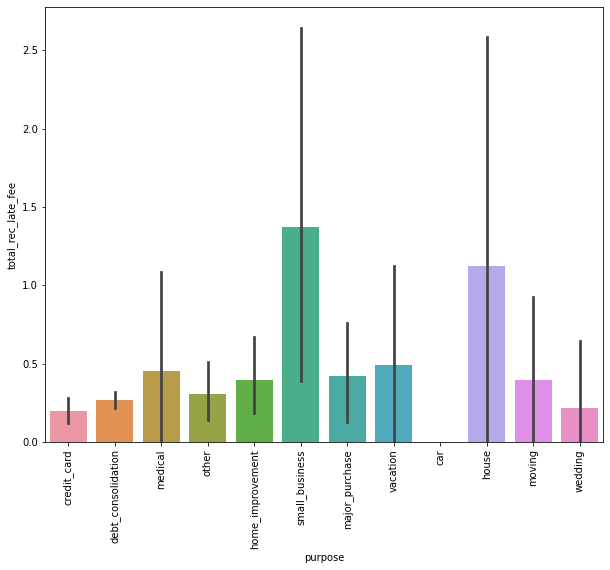

In [25]:
plt.figure(figsize=(10, 8))
sns.barplot(x=df.purpose, y=df.total_rec_late_fee, data=df)
plt.xticks(rotation=90)

Though there's a high variability in the data, most of the late fees are amassed from small businesses and hour loans

<AxesSubplot:>

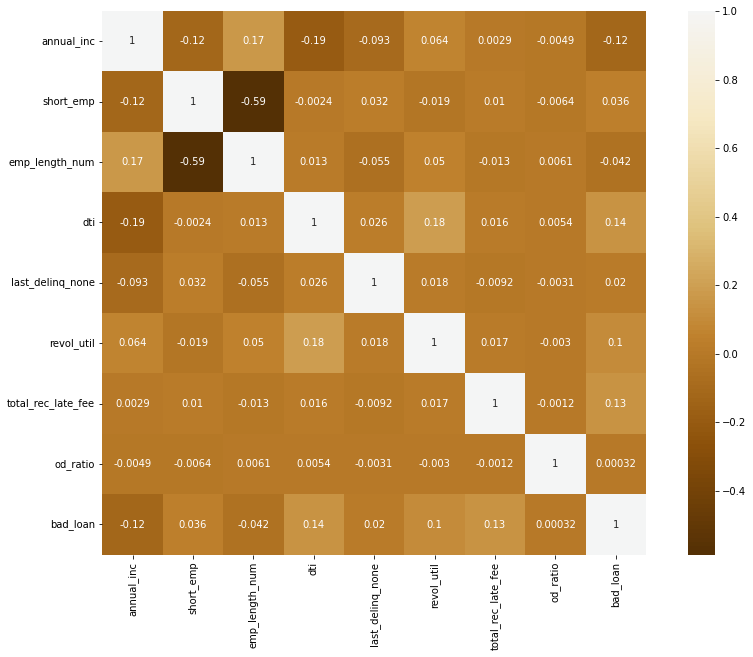

In [26]:
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), annot=True, cmap='BrBG', center=True, square=True)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19072 entries, 0 to 19998
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   grade               19072 non-null  object 
 1   annual_inc          19072 non-null  float64
 2   short_emp           19072 non-null  int64  
 3   emp_length_num      19072 non-null  int64  
 4   home_ownership      19072 non-null  object 
 5   dti                 19072 non-null  float64
 6   purpose             19072 non-null  object 
 7   term                19072 non-null  object 
 8   last_delinq_none    19072 non-null  int64  
 9   revol_util          19072 non-null  float64
 10  total_rec_late_fee  19072 non-null  float64
 11  od_ratio            19072 non-null  float64
 12  bad_loan            19072 non-null  int64  
dtypes: float64(5), int64(4), object(4)
memory usage: 2.5+ MB


In [28]:
# numerical features
X_num = df.select_dtypes(exclude="object").copy(deep=True)
y_num = X_num.bad_loan

X_num.drop('bad_loan', axis=1, inplace=True)

# categorical features
X_cat = df[['grade', 'purpose', 'home_ownership', 'term', 'bad_loan']].copy(deep=True)
y_cat = X_cat.bad_loan

X_cat.drop('bad_loan', axis=1, inplace=True)

### Chi-square test for independence

In [29]:
for col in X_cat.columns:
    table = pd.crosstab(X_cat[col], y_cat)
    print()
    display(table)
    _, pval, _, expected_table = scipy.stats.chi2_contingency(table)
    print(f"p-value: {pval:.25f}")

bad_loan,0,1
grade,,
A,1872,117
B,5065,746
C,4205,1143
D,2440,949
E,1038,516
F,490,338
G,92,61


p-value: 0.0000000000000000000000000



bad_loan,0,1
purpose,,
car,133,29
credit_card,3289,679
debt_consolidation,9453,2411
home_improvement,781,197
house,73,15
major_purchase,270,84
medical,121,37
moving,84,29
other,708,263


p-value: 0.0000000000000041483355817



bad_loan,0,1
home_ownership,,
MORTGAGE,8746,1914
OWN,1231,309
RENT,5225,1647


p-value: 0.0000000000000000000051699



bad_loan,0,1
term,,
36 months,11871,2459
60 months,3331,1411


p-value: 0.0000000000000000000000000


since all p-values are less than 0.5, we rejct the null hypothesis and establish that features have a relationship to the target


### next 
-  One-hot & binary encoding-
- Transformation of factor levels for categorical data

In [30]:
# create a mapping for grades
grade_mapping = {"A":7, "B":6, "C":5, "D":4, "E":3, "F":2, "G":1}

df['grade_CAT'] = df.grade.map(grade_mapping)


# get ohe dummies for columns
term_ohe = pd.get_dummies(df.term)
grade_ohe = pd.get_dummies(df.grade_CAT)
purpose_ohe = pd.get_dummies(df.purpose)
homeOwnership_ohe = pd.get_dummies(df.home_ownership)

df.head()

,grade,annual_inc,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,revol_util,total_rec_late_fee,od_ratio,bad_loan,grade_CAT
0,A,100000.0,1,1,RENT,26.27,credit_card,36 months,1,43.2,0.0,0.160624,0,7
1,A,83000.0,0,4,OWN,5.39,credit_card,36 months,0,21.5,0.0,0.810777,0,7
2,D,78000.0,0,11,MORTGAGE,18.45,debt_consolidation,60 months,1,46.3,0.0,0.035147,1,4
3,D,37536.0,0,6,MORTGAGE,12.28,medical,60 months,0,10.7,0.0,0.534887,1,4
4,D,65000.0,0,11,MORTGAGE,11.26,debt_consolidation,36 months,0,15.2,0.0,0.166500,0,4


In [31]:
# concat dataset with ohe data
df_with_ohe = pd.concat([df, term_ohe, grade_ohe, purpose_ohe, homeOwnership_ohe], axis=1)
df_with_ohe.head()
df_with_ohe["outcome"] = df_with_ohe.bad_loan
# drop repeated columns
df_with_ohe.drop(['grade', 'grade_CAT', 'term', 'purpose', 'home_ownership', 'bad_loan'], axis=1, inplace=True)

df_with_ohe.rename(columns = {1:'grade1', 2:'grade2', 3:'grade3', 4:'grade4', 
                             5:'grade5', 6:'grade6', 7:'grade7'}, inplace = True)
df_with_ohe.head()

,annual_inc,short_emp,emp_length_num,dti,last_delinq_none,revol_util,total_rec_late_fee,od_ratio,36 months,60 months,...,medical,moving,other,small_business,vacation,wedding,MORTGAGE,OWN,RENT,outcome
0,100000.0,1,1,26.27,1,43.2,0.0,0.160624,1,0,...,0,0,0,0,0,0,0,0,1,0
1,83000.0,0,4,5.39,0,21.5,0.0,0.810777,1,0,...,0,0,0,0,0,0,0,1,0,0
2,78000.0,0,11,18.45,1,46.3,0.0,0.035147,0,1,...,0,0,0,0,0,0,1,0,0,1
3,37536.0,0,6,12.28,0,10.7,0.0,0.534887,0,1,...,1,0,0,0,0,0,1,0,0,1
4,65000.0,0,11,11.26,0,15.2,0.0,0.166500,1,0,...,0,0,0,0,0,0,1,0,0,0


In [32]:
df_with_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19072 entries, 0 to 19998
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   annual_inc          19072 non-null  float64
 1   short_emp           19072 non-null  int64  
 2   emp_length_num      19072 non-null  int64  
 3   dti                 19072 non-null  float64
 4   last_delinq_none    19072 non-null  int64  
 5   revol_util          19072 non-null  float64
 6   total_rec_late_fee  19072 non-null  float64
 7   od_ratio            19072 non-null  float64
 8    36 months          19072 non-null  uint8  
 9    60 months          19072 non-null  uint8  
 10  grade1              19072 non-null  uint8  
 11  grade2              19072 non-null  uint8  
 12  grade3              19072 non-null  uint8  
 13  grade4              19072 non-null  uint8  
 14  grade5              19072 non-null  uint8  
 15  grade6              19072 non-null  uint8  
 16  grad

<AxesSubplot:>

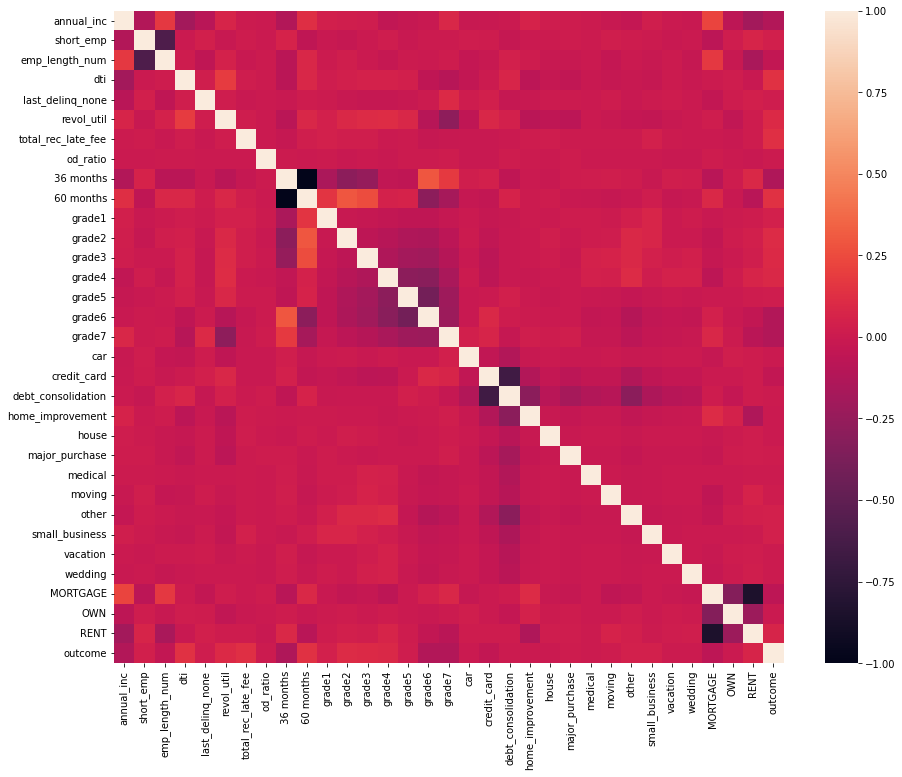

In [33]:
plt.figure(figsize=(15, 12))
sns.heatmap(df_with_ohe.corr())

### Predictive Models

In [34]:
std_sc = StandardScaler()

features = df_with_ohe.columns.values[:-1]

# features
X = pd.DataFrame(std_sc.fit_transform(df_with_ohe.drop(["outcome"], axis=1), ), columns=features)

#target
y = df_with_ohe.outcome

In [35]:
selector = SelectPercentile(f_classif, percentile=40)
selector.fit(X, y)
best_features_idx = selector.get_support()
best_features = [features[f]
                for f in range(len(features))
                    if best_features_idx[f]]
best_features

['annual_inc',
 'dti',
 'revol_util',
 'total_rec_late_fee',
 ' 36 months',
 ' 60 months',
 'grade2',
 'grade3',
 'grade4',
 'grade6',
 'grade7',
 'MORTGAGE',
 'RENT']

In [36]:
df_op = df_with_ohe[['annual_inc', 'dti', 'revol_util', 
                     'total_rec_late_fee', ' 36 months', ' 60 months', 'grade2',
                     'grade3', 'grade4', 'grade6', 'grade7', 'MORTGAGE', 'RENT', 'outcome']]

In [37]:
def calculate_model_accuracy(model):
    df_op_copy = df_op.copy(deep=True)
    # features
    X_op = pd.DataFrame(std_sc.fit_transform(
                            df_op.drop(["outcome"], axis=1), ), 
                            columns= best_features)

    #target
    y_op = df_op.outcome

    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_op, y_op, 
                                                        test_size=0.20,
                                                        stratify=y_op,
                                                        random_state=24)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print("Accuracy score: ")
    print(metrics.accuracy_score(y_test, y_pred))
    
    print("\n\nClassification report: ")
    print(metrics.classification_report(y_test, y_pred))
    
    print("\n\nConfusion matrix: ")
    print(metrics.confusion_matrix(y_test, y_pred))
    
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
    
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    print("\n\nROC AUC score: ")
    print(metrics.roc_auc_score(y_test, y_pred_proba))
    
    def roc_auc_plot(y_test, y_pred_proba):
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba)
        
        roc_auc = metrics.auc(fpr, tpr)
        
        plt.plot(fpr, tpr)
        plt.plot([0,1],[0,1],'*-')
        
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiving Operating Characteristic')
        return roc_auc
    auc = roc_auc_plot(y_test=y_test, y_pred_proba=y_pred_proba)
    
    return tn, fp, fn, tp, auc
       
seed = 276

### Logistic Regression

In [38]:
lr = LogisticRegression()

In [39]:
df_op_grid = df_op.copy(deep=True)

# features
X_op = pd.DataFrame(std_sc.fit_transform(df_op.drop(["outcome"], axis=1), ), columns=best_features)

#target
y_op = df_op.outcome

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_op, y_op, 
                                                    test_size=0.20,
                                                    stratify=y_op,
                                                    random_state=24)

parameters = {'C':[0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(lr, parameters, cv = 10).fit(X_train, y_train)
print("Best Estimator: ", grid.best_estimator_)

Best Estimator:  LogisticRegression(C=1)


Accuracy score: 
0.6537352555701179


Classification report: 
              precision    recall  f1-score   support

           0       0.89      0.65      0.75      3041
           1       0.33      0.68      0.44       774

    accuracy                           0.65      3815
   macro avg       0.61      0.66      0.60      3815
weighted avg       0.77      0.65      0.69      3815



Confusion matrix: 
[[1969 1072]
 [ 249  525]]


ROC AUC score: 
0.7197699485158476


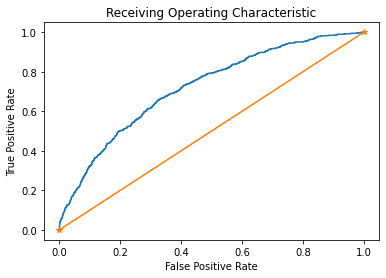

In [40]:
lr = LogisticRegression(C=0.001, class_weight='balanced', max_iter=1000, random_state=276)
tn_lr, fp_lr, fn_lr, tp_lr, auc_lr = calculate_model_accuracy(lr)

total_obs = tn_lr + fp_lr + fn_lr + tp_lr

### KNN

In [41]:
# randomsearchCV to find the optimal n_neighbours for KNN
knn = KNeighborsClassifier()
k_range = list(range(1, 51))
weight_options = ["uniform", "distance"]
param_dist = dict(n_neighbors = k_range, weights = weight_options)
rand = RandomizedSearchCV(knn, param_dist, cv=10, scoring="accuracy", random_state=100)
rand.fit(X, y)
print(rand.best_params_)

{'weights': 'uniform', 'n_neighbors': 32}


Accuracy score: 
0.8018348623853211


Classification report: 
              precision    recall  f1-score   support

           0       0.81      0.99      0.89      3041
           1       0.60      0.07      0.13       774

    accuracy                           0.80      3815
   macro avg       0.70      0.53      0.51      3815
weighted avg       0.76      0.80      0.73      3815



Confusion matrix: 
[[3004   37]
 [ 719   55]]


ROC AUC score: 
0.7010652010804959


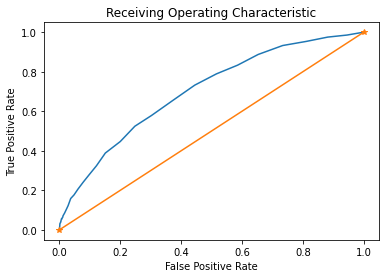

In [42]:
knn = KNeighborsClassifier(n_neighbors=47, weights='uniform')

tn_knn, fp_knn, fn_knn, tp_knn, auc_knn = calculate_model_accuracy(knn)

### Decision Tree

Accuracy score: 
0.708256880733945


Classification report: 
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      3041
           1       0.28      0.29      0.29       774

    accuracy                           0.71      3815
   macro avg       0.55      0.55      0.55      3815
weighted avg       0.71      0.71      0.71      3815



Confusion matrix: 
[[2479  562]
 [ 551  223]]


ROC AUC score: 
0.5516530330105271


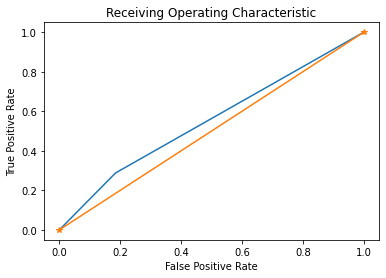

In [43]:
dec_tree = DecisionTreeClassifier()
tn_dt, fp_dt, fn_dt, tp_dt, auc_dt = calculate_model_accuracy(dec_tree)

### SVM

[LibSVM]..............
*......*
optimization finished, #iter = 20424
obj = -8606.758274, rho = -0.514730
nSV = 8948, nBSV = 7356
Total nSV = 8948
...............
*.........*..*
optimization finished, #iter = 25452
obj = -8647.800471, rho = -0.496664
nSV = 9005, nBSV = 7404
Total nSV = 9005
..............
*.......*.*
optimization finished, #iter = 22019
obj = -8782.973211, rho = -0.568416
nSV = 9105, nBSV = 7532
Total nSV = 9105
...............
*......*.
*
optimization finished, #iter = 21979
obj = -8695.186613, rho = -0.497654
nSV = 9022, nBSV = 7377
Total nSV = 9022
..............
*......*.
*
optimization finished, #iter = 20739
obj = -8797.958704, rho = -0.524557
nSV = 9114, nBSV = 7520
Total nSV = 9114
...................
*.........*.*
optimization finished, #iter = 28623
obj = -10899.669601, rho = 0.532067
nSV = 11281, nBSV = 8796
Total nSV = 11281
Accuracy score: 
0.6304062909567497


Classification report: 
              precision    recall  f1-score   support

           0      

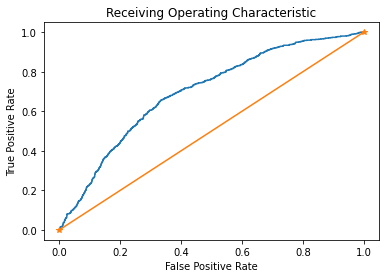

In [44]:
svc = SVC(random_state=seed, class_weight='balanced',probability=True, verbose=True)

tn_svm, fp_svm, fn_svm, tp_svm, auc_svm = calculate_model_accuracy(svc)

### Random Forest

Accuracy score: 
0.783748361730013


Classification report: 
              precision    recall  f1-score   support

           0       0.81      0.95      0.88      3041
           1       0.40      0.13      0.20       774

    accuracy                           0.78      3815
   macro avg       0.60      0.54      0.54      3815
weighted avg       0.73      0.78      0.74      3815



Confusion matrix: 
[[2890  151]
 [ 674  100]]


ROC AUC score: 
0.6515353901502889


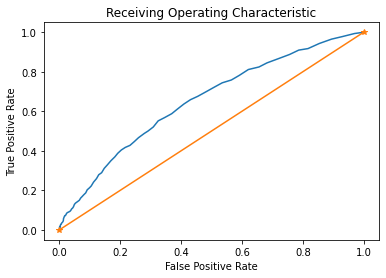

In [45]:
rfc = RandomForestClassifier(n_estimators=100)
tn_rfc, fp_rfc, fn_rfc, tp_rfc, auc_rfc = calculate_model_accuracy(rfc)

### Performance table

In [46]:
performance_mapping = {
    'Classifier': ['ROC AUC (%)', 'TN (%)','FP (%)','FN (%)','TP (%)'],
    'Logistic Regression': [(auc_lr*100).round(2), ((tn_lr/total_obs)*100).round(2),
                           ((fp_lr/total_obs)*100).round(2), 
                           ((fn_lr/total_obs)*100).round(2),
                           ((tp_lr/total_obs)*100).round(2)],
    'KNN': [(auc_knn*100).round(2), ((tn_knn/total_obs)*100).round(2),
                           ((fp_knn/total_obs)*100).round(2), 
                           ((fn_knn/total_obs)*100).round(2),
                           ((tp_knn/total_obs)*100).round(2)],
    'Decision Tree': [(auc_dt*100).round(2), ((tn_dt/total_obs)*100).round(2),
                           ((fp_dt/total_obs)*100).round(2), 
                           ((fn_dt/total_obs)*100).round(2),
                           ((tp_dt/total_obs)*100).round(2)],
    'Support Vector Machine': [(auc_svm*100).round(2), ((tn_svm/total_obs)*100).round(2),
                           ((fp_svm/total_obs)*100).round(2), 
                           ((fn_svm/total_obs)*100).round(2),
                           ((tp_svm/total_obs)*100).round(2)],
    'Random Forest': [(auc_rfc*100).round(2), ((tn_rfc/total_obs)*100).round(2),
                           ((fp_rfc/total_obs)*100).round(2), 
                           ((fn_rfc/total_obs)*100).round(2),
                           ((tp_rfc/total_obs)*100).round(2)]
}

df_results = pd.DataFrame(performance_mapping, 
                          columns=['Classifier', 
                                   'Logistic Regression',
                                   'KNN',
                                   'Decision Tree',
                                   'Support Vector Machine',
                                   'Random Forest'
                                ])
df_results.set_index("Classifier", inplace=True)
results = df_results.T
results

Classifier,ROC AUC (%),TN (%),FP (%),FN (%),TP (%)
Logistic Regression,71.98,51.61,28.10,6.53,13.76
KNN,70.11,78.74,0.97,18.85,1.44
Decision Tree,55.17,64.98,14.73,14.44,5.85
Support Vector Machine,69.65,48.94,30.77,6.19,14.10
Random Forest,65.15,75.75,3.96,17.67,2.62


Logistic Regression performs the best among the chosen models with a 71.98% AUC